# Задача 12. Экспериментальное исследование алгоритмов решения задачи достижимости с КС ограничениями

### Установка пакетов

In [ ]:
%% capture
!pip install pycubool seaborn matplotlib
!pip install -r../ requirements.txt

In [ ]:
import pathlib, sys, importlib.util

if importlib.util.find_spec("project") is None:
    sys.path.append(str(pathlib.Path.cwd().parent))

# Введение
Исследование посвящено анализу производительности различных алгоритмов решения задачи достижимости между всеми парами вершин с контекстно-свободными ограничениями: алгоритма Хеллингса, матричного алгоритма, тензорного алгоритма и сравнению этих алгоритмов между собой и с алгоритмами решения задачи достижимости с регулярными ограничениями: тензорным алгоритмом и алгоритмом, основанном на синхронном обходе в ширину.


## Исследуемые алгоритмы
Будут использованы следующие алгоритмы решения задачи достижимости с **контекстно-свободными ограничениями**:
1. **Алгоритм Хеллингса**
Идея: используем грамматику в виде обобщённой нормальной формы Хомского (ОНФХ). Для каждого нетерминала храним выводимые пути из вершин в какие вершины. На каждой итерации берём один путь, который ранее не брали, и пытаемся соединить к нему другие ранее найденные выводимые пути.
2. **Матричный алгоритм**
Идея: используем грамматику в виде обобщённой нормальной формы Хомского. Храним матрицу достижимости. Её элементы это множества нетерминалов, из которых выводимы пути между вершинами. На каждой итерации прибавляем к матрице достижимости её квадрат. Выполняем до тех пор, пока матрица меняется.
3. **Тензорный алгоритм**
Идея: используем рекурсивный автомат, полученный по грамматике. На каждой итерации находим пересечение графа и автомата с помощью произведения Кронокера. После добавляем в граф ребра с метками нетерминалами для тех пар вершин, для которых были найдены пути, выводимые из этих нетерминалов.

Будет использоваться следующий алгоритм для решения задачи достижимости с **регулярными ограничениями**:
1. **Тензорный алгоритм**
Идея: с помощью произведения Кронекера находим матрицу смежности конечного автомата, распознающего пересечение языков, задаваемых графом и запросом, после этого находим транзитивное замыкание этой матрицы.

# Исследовательские вопросы
1. Какой из трёх алгоритмов решения задачи достижимости между всеми парами вершин с контекстно-свободными (КС) ограничениями обладает лучшей производительностью?

2. Имеет ли смысл для решения задачи достижимости с регулярными ограничениями использовать алгоритмы для КС ограничений (ведь регулярные --- частный случай КС) или всё же лучше использовать специализированные алгоритмы для регулярных ограничений?

# Постановка экспериментов
### Оборудование

In [79]:
! printf '========== OS  ==========\n'
! hostnamectl | grep -a 'Operating System'

! printf '\n========== CPU ==========\n'
!lscpu | grep -E 'Architecture|Model name|Thread|Core|MHz'

! printf '\n========== RAM ==========\n'
! free -m

========== OS  ==========
Operating System: Ubuntu 22.04.1 LTS

========== CPU ==========
Architecture:                    x86_64
Model name:                      AMD Ryzen 5 4600H with Radeon Graphics
Thread(s) per core:              2
Core(s) per socket:              6
CPU max MHz:                     3000.0000
CPU min MHz:                     1400.0000

========== RAM ==========
               total        used        free      shared  buff/cache   available
Mem:           15414        6478        3864          57        5070        8558
Swap:              0           0           0


### Описание набора данных
Графы для проведения экспериментов были взяты из [CFPQ_Data](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/index.html)
Для более показательной работы алгоритмов были выбраны данные из разных областей:
1. Анализ RFG
2. Анализ указателей в C
3. Анализ Java-программ

In [ ]:
import cfpq_data
import pandas

from project.graphs_util import get_info_from_graph
from project.graphs_util import get_graph_by_name

cfpq_data.logging.disable()


def generate_graphs(names):
    res = []
    for name in names:
        graph = get_graph_by_name(name)
        graph.name = name
        res.append(graph)
    return res


rdf_graphs = generate_graphs(["pizza", "core", "pathways"])
c_graphs = generate_graphs(["bzip", "gzip", "wc"])
java_graphs = generate_graphs(["lusearch"])

all_graphs = sorted(rdf_graphs + c_graphs + java_graphs, key=lambda graph: graph.number_of_edges())

In [ ]:
stats = []
for graph in all_graphs:
    info = get_info_from_graph(graph.name)
    stats.append([graph.name, info[1] * 2, info[0]])

pandas.DataFrame(stats, columns=["Graph name", "Edges", "Nodes"])

### Запросы
Для каждого графа были выбраны контекстно-свободные и регулярные запросы. Для каждого графа были выбраны грамматики из раздела "Canonical grammars" в описании соответствующего графа.

#### Контекстно-свободные запросы
* RDF графы
1. S -> subClassOf_r S subClassOf | subClassOf_r subClassOf
2. S -> type_r S type | type_r type
3. S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type
* Графы для C
1. S -> d_r V d
2. V -> V1 V2 V3
3. V1 -> epsilon
4. V1 -> V2 a_r V1
5. V2 -> epsilon
6. V2 -> S
7. V3 -> epsilon
8. V3 -> a V2 V3
* Графы для Java
1. S -> PTh alloc
2. PTh -> epsilon
3. PTh -> assign PTh
4. (for each field f) PTh -> load_f Al store_f PTh
5. FT -> alloc_r FTh
6. FTh -> epsilon
7. FTh -> assign_r FTh
8. (for each field f) FTh -> store_f_r Al load_f_r FTh
9. Al -> S FT

#### Регулярные запросы
Для генерации регулярных выражений используются 4 самые распространенные метки на ребрах графа и строятся по следующему шаблону, где $l_1$, $l_2$, $l_3$, $l_4$ метки ребер:

1. $l_1^* \ (l_2 \ | \ l_3)$
2. $(l_3 \ | \ l_4)+ \ l_1^*$
3. $l_1 \ l_2 \ (l_3 \ | \ l_1)^* \ l_4$

In [ ]:
from pyformlang.cfg import CFG

c_cfg = {
    "c_alias": CFG.from_text(
        """
        S -> d_r V d
        V -> V1 V2 V3
        V1 -> epsilon
        V1 -> V2 a_r V1
        V2 -> epsilon
        V2 -> S
        V3 -> epsilon
        V3 -> a V2 V3
        """
    )
}

rdf_cfg = {
    "1_rdf": CFG.from_text(
        """
        S -> subClassOf_r S subClassOf | subClassOf_r subClassOf
        """),
    "2_rdf": CFG.from_text(
        """
        S -> type_r S type | type_r type
        """
    ),
    "3_rdf": CFG.from_text(
        """
        S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type
        """
    )
}


def java_cfg(graph):
    path_to_cfg = cfpq_data.download_grammars("java_points_to", graph_name=graph.name)
    assert path_to_cfg is not None
    path_to_cfg = path_to_cfg / f"java_points_to_{graph.name}.txt"
    assert path_to_cfg.exists()
    return {"java_points_to": cfpq_data.cfg_from_txt(path_to_cfg)}

In [ ]:
from collections import Counter

from pyformlang.regular_expression import Regex, regex_objects


def reg_to_cfg(reg):
    return lambda l1, l2, l3, l4: reg(l1, l2, l3, l4).to_cfg()


def reg_by_str(str):
    r = Regex("")
    r.head = regex_objects.Symbol(str)
    return r


def reg1(l1, l2, l3, l4):
    r1 = reg_by_str(l1)
    r2 = reg_by_str(l2)
    r3 = reg_by_str(l3)

    r1 = r1.kleene_star()
    r23 = r2.union(r3)

    return r1.concatenate(r23)


def reg2(l1, l2, l3, l4):
    r1 = reg_by_str(l1)
    r2 = reg_by_str(l2)
    r3 = reg_by_str(l3)

    r23 = r2.union(r3)
    r23 = r23.concatenate(r23.kleene_star())
    r1 = r1.kleene_star()

    return r23.concatenate(r1)


def reg3(l1, l2, l3, l4):
    r1 = reg_by_str(l1)
    r2 = reg_by_str(l2)
    r3 = reg_by_str(l3)
    r4 = reg_by_str(l4)

    r31 = r3.union(r1)
    r31 = r31.kleene_star()

    return r1.concatenate(r2).concatenate(r31).concatenate(r4)


regs = {
    str("l1* (l2 | l3)"): (reg1, reg_to_cfg(reg1)),
    str("(l3 | l4)+ l1*"): (reg2, reg_to_cfg(reg2)),
    str("l1 l2 (l3 | l1)* l4"): (reg3, reg_to_cfg(reg3))
}


def get_most_common(source):
    return sorted(
        Counter(source).most_common(4), key=lambda x: (x[1], x[0]), reverse=True
    )


def get_rqs(graph):
    info = get_info_from_graph(graph.name)
    labels = get_most_common(info[2])
    while len(labels) < 4:
        labels += labels
    labels = [l for l, _ in labels[:4]]
    return [
        (name, reg(*labels), cfg(*labels)) for (name, (reg, cfg)) in regs.items()
    ]

## Замеры
##### Какой из трёх указанных алгоритмов обладает лучшей производительностью?
Для ответа на этот вопрос, было замерено время работы алгоритма Хеллингса, матричного алгоритма и тензорного алгоритма на выбранных графах с использованием для каждого графа его канонических КС-запросов и выбранных ранее регулярных запросов.

##### Имеет ли смысл для решения задачи достижимости с регулярными ограничениями использовать алгоритмы для КС ограничений (ведь регулярные --- частный случай КС) или всё же лучше использовать специализированные алгоритмы для регулярных ограничений?
Для ответа на этот вопрос, было замерено время работы всех рассмотренных ранее алгоритмов на всех комбинациях выбранных графов и регулярных запросов.


In [ ]:
import signal
import timeit


def get_cf_qs(graph):
    if graph in rdf_graphs:
        return list(rdf_cfg.items())
    elif graph in c_graphs:
        return list(c_cfg.items())
    elif graph in java_graphs:
        return list(java_cfg(graph).items())


class RunTimeoutError(Exception):
    pass


def timeout_handler(_signum, _frame):
    raise RunTimeoutError


def run_with_time(func, run_times=10, timeout_each=1):
    total_timeout = run_times * timeout_each
    signal.signal(signal.SIGALRM, timeout_handler)
    try:
        signal.alarm(total_timeout)
        times = timeit.repeat(func, setup="gc.enable()", repeat=run_times, number=1)
    except Exception as e:
        if isinstance(e, RunTimeoutError):
            print("Time is out", end=" ")
        else:
            print("Memory is out", end=" ")
        times = []
    finally:
        signal.alarm(0)

    return times

In [ ]:
from project.cfpq import cfpq, CfpqAlgorithms
from cuda_cfpq import cfpq_matrix, cfpq_tensor
import csv

file_name = "experiment_results.csv"
columns = ("Граф", "Тип запроса", "Запрос", "Тип алгоритма", "Алгоритм", "Время, сек.")


def init_result_file():
    if pathlib.Path(file_name).exists():
        return False
    with open(file_name, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(columns)
    return True


def save_results(res):
    with open(file_name, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(res)


def experiment():
    if not init_result_file():
        print(f"Ошибка: {file_name} уже существует")
        # return

    for graph_i, graph in enumerate(all_graphs, start=1):
        print(f"============= Graph {graph.name}: {graph_i}/{len(all_graphs)} =============")
        cf_qs = get_cf_qs(graph)

        for query_i, (query_name, query) in enumerate(cf_qs, start=1):
            print(f"~~~~~~~~~ CFPQ {query_i}/{len(cf_qs)} ~~~~~~~~~")

            def run(algorithm: str, func):
                print(algorithm, end=" ")
                times = run_with_time(func)
                print(times)
                save_results([
                    (graph.name, "CFPQ", query_name, "CFPQ", algorithm, time)
                    for time in times
                ])

            run("Hellings", lambda: cfpq(query, graph, algorithm=CfpqAlgorithms.HELLINGS))
            run("matrix", lambda: cfpq_matrix(query, graph))
            run("tensor CFPQ", lambda: cfpq_tensor(query, graph))

        req_qs = get_rqs(graph)
        for q_i, (query_name, query_reg, query_cfg) in enumerate(req_qs, start=1):
            print(f"~~~~~~~~~ RPQ {q_i} / {len(req_qs)} ~~~~~~~~~")

            def run(algorithm, algorithm_type, func):
                print(algorithm, end=" ")
                times = run_with_time(func)
                print(times)
                save_results([
                    (graph.name, "RPQ", query_name, algorithm_type, algorithm, time)
                    for time in times
                ])

            run("hellings", "CFPQ", lambda: cfpq(query_cfg, graph, algorithm=CfpqAlgorithms.HELLINGS))
            run("matrix", "CFPQ", lambda: cfpq_matrix(graph, query_cfg))
            run("tensor (CFPQ)", "CFPQ", lambda: cfpq_tensor(graph, query_cfg))
            run("tensor (RPQ)", "RPQ", lambda: cfpq_tensor(graph, query_reg))

In [ ]:
experiment()

# Результаты

### Результаты в сравнении производительности контекстно-свободных алгоритмов(Вопрос 1)

In [ ]:
%%capture
import matplotlib.pyplot as plt
import seaborn as sns

raw = pandas.read_csv(file_name)

plot = raw.copy()
plot["Measure"] = plot["Запрос"] + " - " + plot["Граф"]
plot.drop(columns=["Граф", "Запрос"])

plt.ion()

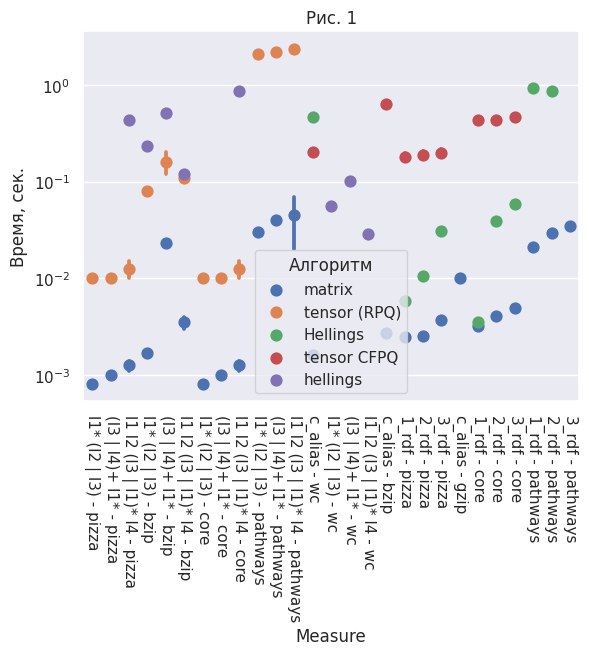

In [78]:
def plot_cfpq_results():
    res = plot[plot["Тип алгоритма"] == "CFPQ"].copy()
    res["Алгоритм"] = res["Алгоритм"].map(lambda s: s.removesuffix(" (CFPQ)"))

    ax = plt.subplot()
    ax.set(yscale="log")
    g = sns.pointplot(
        data=res,
        x="Measure",
        y="Время, сек.",
        hue="Алгоритм",
        join=False,
        ax=ax,
    )
    g.set_title("Рис. 1")
    g.set_xticklabels(g.get_xticklabels(), rotation=270)


plot_cfpq_results()

На Рис. 1 приведены результаты замеров для контекстно-свободных запросов.
Можно заметить, что *матричный алгоритм* оказался наиболее быстрым. Так же стоит отметить, что для большинства запросов на графе lusearch доступного объема видеопамяти для запуска матричного алгоритма уже не хватило.

### Результаты сравнения использования регулярных ограничений в качестве для КС алгоритмов(Вопрос 2)

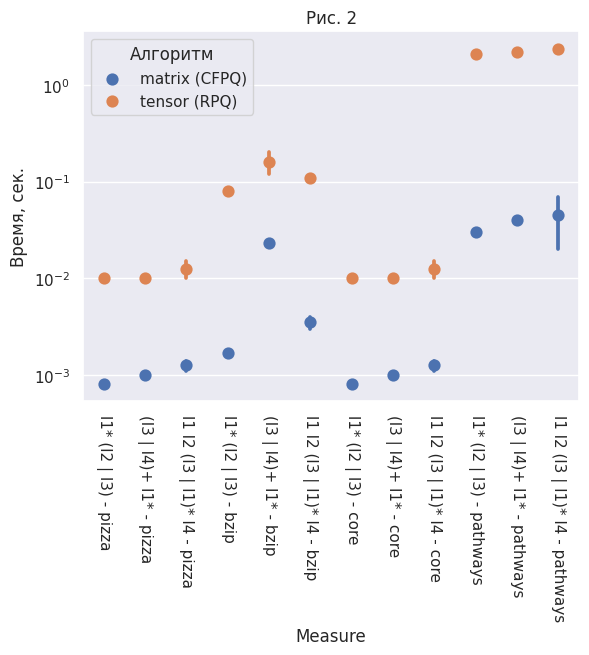

In [76]:
raw = pandas.read_csv(file_name)

plot = raw.copy()
plot["Measure"] = plot["Запрос"] + " - " + plot["Граф"]
plot.drop(columns=["Граф", "Запрос"])

plt.ion()

def plot_reg_results():
    res = plot[
        (plot["Тип запроса"] == "RPQ") & (plot["Алгоритм"].isin(["matrix", "tensor (RPQ)"]))].copy()
    res["Алгоритм"] = res["Алгоритм"].map(lambda s: s + " (CFPQ)" if s == "matrix" else s)

    ax = plt.subplot()
    ax.set(yscale="log")
    g = sns.pointplot(
        data=res,
        x="Measure",
        y="Время, сек.",
        hue="Алгоритм",
        join=False,
        ax=ax,
    )
    g.set_title("Рис. 2")
    g.set_xticklabels(g.get_xticklabels(), rotation=270)


plot_reg_results()

Замеры показали, что матричный алгоритм для контекстно-свободных ограничений оказался быстрее, чем алгоритм, основанный на регулярных ограничениях.

# Заключение

В результате были получены следующие выводы:

Самым эффективным алгоритмом является матричный. Однако, для него требуется большое количество видеопамяти. В связи с этим возникают проблемы запуска на больших графах. В это же время, такие графы может обработать алгоритм Хеллингса.

Применение специализированных алгоритмов для регулярных запросов не имеет смысла, так как реализация матричного алгоритма для контекстно-свободных запросов оказывается быстрее и охватывает более широкое множество возможных запросов.